#House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

## 1. 데이터 로드

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155047 files and di

In [1]:
! pip install googlemaps
! pip install xlrd

import io
import os
from google.colab import files
from google.colab import drive
import pandas as pd
import folium
import numpy as np
import googlemaps
import math
from folium.features import DivIcon
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
import random
from scipy.stats import expon, reciprocal
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
from random import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train=pd.read_csv('/content/gdrive/MyDrive/prac/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
test=pd.read_csv('/content/gdrive/MyDrive/prac/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
submission=pd.read_csv('/content/gdrive/MyDrive/prac/house-prices-advanced-regression-techniques/sample_submission.csv', index_col='Id')
data=train
print(train.shape, test.shape, submission.shape)

(1460, 80) (1459, 79) (1459, 1)


총 1460 행의 train 데이터를 가지고 1459 행의 test 데이터의 집값을 예측해야 한다. 이때 변수는 79개... 로 꽤나 많이 주어진다. 손이 많이 갈 것이다. 

## 2. 데이터 분석

### 2.1. target 변수 확인

이번 대회는 Regression 문제인 만큼 더더욱 타겟 변수의 분포를 확인해야 할 필요성

In [4]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


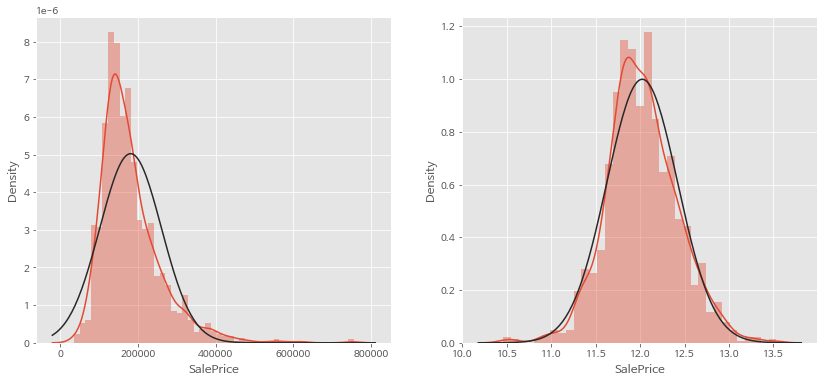

In [5]:
from scipy.stats import norm

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(data['SalePrice'], fit = norm, ax=ax1)
sns.distplot(np.log(data['SalePrice']+1),fit = norm, ax=ax2)

왼쪽 그래프를 대충 보아도 약 400000 정도 값이 중심인 것을 알 수 있다. 
하지만 많은 데이터가 400000보다 왼쪽으로 치우쳐 있는데, 이렇게 데이터의 분포가 비대칭인 정도를 'Skewness' 라고 한다. 한국어로 번역하면 '왜도' 라고 한다. 
이 Skewness의 꼬리가 오른쪽으로 길게 있으면 'Right Skewed' 또는 'Positive Skewed', 왼쪽으로 길게 있으면 'Left Skewed' 또는 'Negative Skewed' 라고 한다. 
오른쪽이든 왼쪽이든 심한 비대칭은 머신러닝 알고리즘이 학습을 잘 하지 못하도록 방해하는 요소 중 하나이다. 대부분의 데이터가 왼쪽에 있다면, 오른쪽 꼬리 부분은 데이터가 적어서 학습이 잘 안될 가능성이 있다. 따라서 예측 결과물도 의심할 수 밖에 없다. 이런 상황에서 'Right Skewed' 를 해결하는 대표적인 방법이 바로 해당 변수에 

'로그'를 취하는 것이다. 키야~ 로그에 취한다~

확실히 로그를 취하면 비대칭도가 줄어들고, 정규분포에 가깝게 데이터가 분포되어 있는 것을 확인할 수 있다. 우리는 이렇게, 머신러닝에게 로그를 취한 값을 타겟 변수로 주어서 예측하게끔 한 다음에, 마지막에 제출할 때만 지수 계산을 해서 제출하면 그만이다. 

그럼 조금 이따가 타겟 변수에 로그를 취하고, 다른 그래프도 띄워보자. 

### 2.2. 변수간 상관관계 확인 (Feature Correlation)

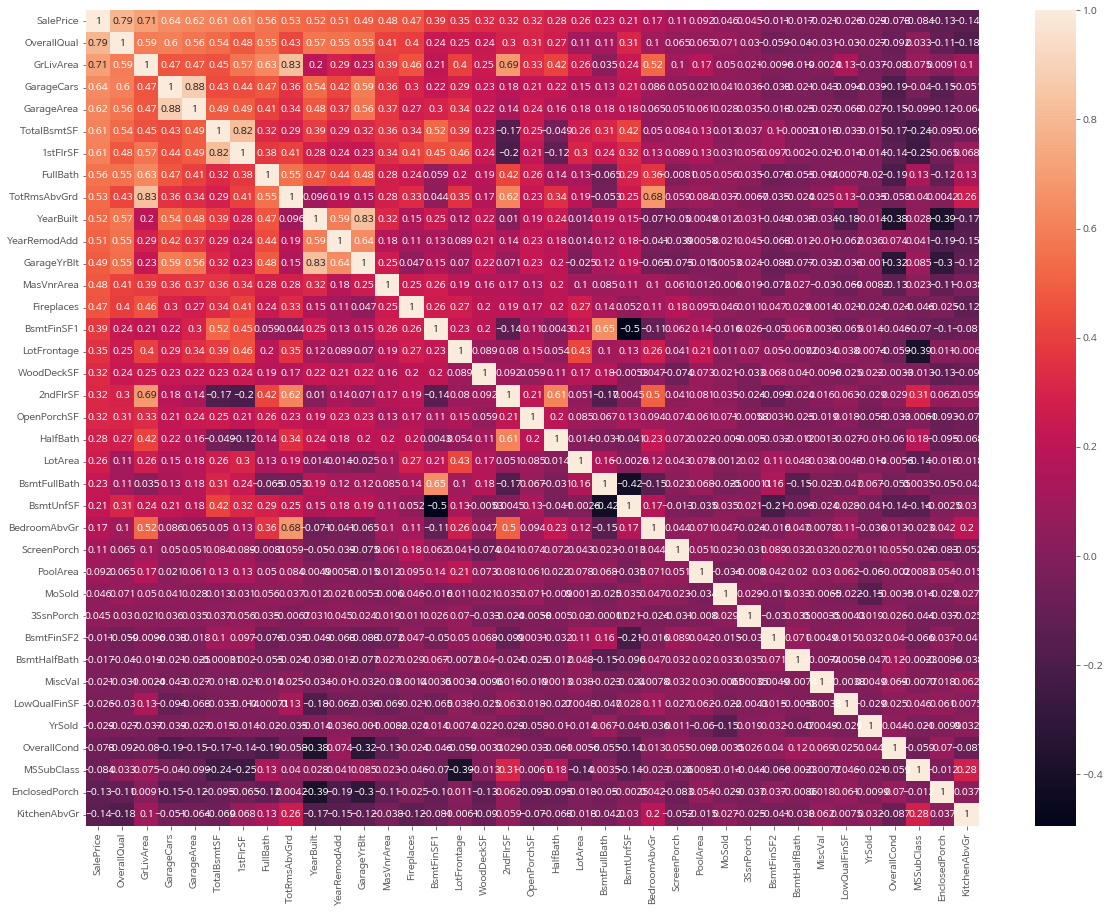

In [6]:
corr=data.corr()
top_corr=data[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

 그래프는 타겟 변수인 'SalePrice' 와 가장 큰 상관관계를 가진 40개의 변수를 표시하는 그래프이다.

 그래프를 뜯어보면, 변수 'OverallQual' 이라는 변수가 상관계수 0.79로 타겟변수와 가장 큰 상관관계를 가지고 있는 것으로 나타났다. 
 
 전반적으로 OverallQual 이 증가하면, 집값도 증가한다고 볼 수 있다는 뜻이다. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


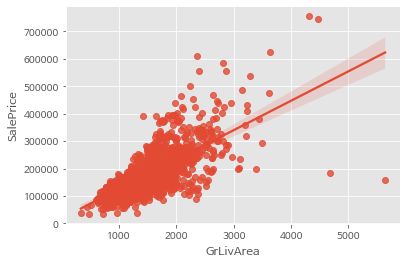

In [7]:
sns.regplot(data['GrLivArea'], data['SalePrice'])

두번째로 큰 상관계수를 가진 'GrLivArea' 의 그래프를 띄워보면 위와 같다. 전체적으로 'GrLivArea' 가 증가하면 집값도 증가한다는 것을 확인할 수 있다. 다만 눈에 약간 거슬리는 부분이 있는데, 오른쪽 아래에 점 두개이다. 저 점들의 분포는 그래프 상의 저 직선으로 표현이 가능한데, 오른쪽 아래에 있는 저 두 점들은 전혀 다른 결과를 보여주고 있다. 저런 데이터들을 '이상치' (Outlier)로 간주하고 삭제해주는 것도 머신러닝의 정확도를 높일 수 있는 방법 중 하나

In [8]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


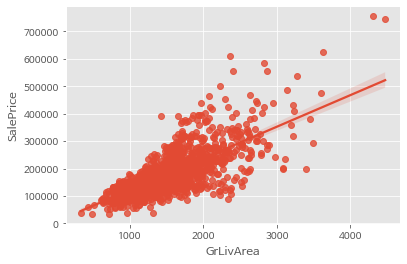

In [9]:
sns.regplot(train['GrLivArea'], train['SalePrice'])

이제 본격적으로 데이터를 처리할 준비를 한다. 타이타닉에서 했던 것처럼 train 과 test 에 코드를 두번 쓰지 않고, train 과 test 를 묶어서 all_data 라는 변수에 저장한 후 이를 처리하고, 머신러닝에 학습시키기 전에 다시 자를것이다.

In [10]:
Ytrain=train['SalePrice'] #Y빼두고
train=train[list(test)] #Y제외하고 피쳐 맞추고
all_data=pd.concat((train, test), axis=0) #train이랑 test 병합
print(all_data.shape)
Ytrain=np.log(Ytrain+1) #분포 로그취해서 중간으로 맞추기

(2917, 79)


타겟 변수를 미리 Ytrain으로 빼서 저장하고 위에서 말한듯이 로그를 씌웠다. 로그를 씌우는데 +1 을 해주는 이유는 log0 의 값이 없기 때문이다. 공짜 집은 없겠지만 만약 Ytrain의 값중 하나가 0이라면..? log0은 마이너스 무한대로 커지기 때문에 +1씩 해주어서 이를 방지한다. 이를 'log1p' 라고 하기도 한다. 

### 2.3. 전체 데이터에서 결측치 확인 (Check Missing Values)

In [11]:
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col) ##결측치가 없으면 열 이름 지움
    else:
        pass
print(len(cols))

34


list(all_data) 를 사용하면 all_data 라는 데이터프레임의 열 이름을 리스트로 만들 수 있다. 다음 코드는 반복문을 통해서 all_data 에서 해당 열에 결측치가 없으면 리스트에서 그 열의 이름을 지운다. 그러면 남은 리스트에는 결측치가 있는 변수 이름만 남아있을 것이다. print 문으로 출력해보면 아래 코드에 있는 이름들이 나올 것이다. 

In [12]:
cols

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [13]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


첫번째, 집에 해당 시설물이 없는 경우 (범주형 변수), 이때는 결측치를 'None' 이라는 문자열로 채운다. (이 작은 따옴표 없는 None 과 문자열 'None' 은 다르다!)

두번째, 집에 해당 시설물이 없는 경우(수치형 변수), 이때는 결측치를 0으로 채운다. 차고면적=0 이면 차고 없음 이런식으로 생각할 수 있다. 

세번째, 해당 시설물이 없다고 보기 힘든 경우에 있는 결측치, 이때는 결측치를 해당 열의 최빈값으로 채운다. 집에 외벽 시설이 없을리는 없고, 집이 판매가 되었는데 거래 타입이 정해지지 않을리는 없다. 

### 2.4. 본격적으로 데이터 분석 (EDA)

#### 총 가용면적 (Total SF Available)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

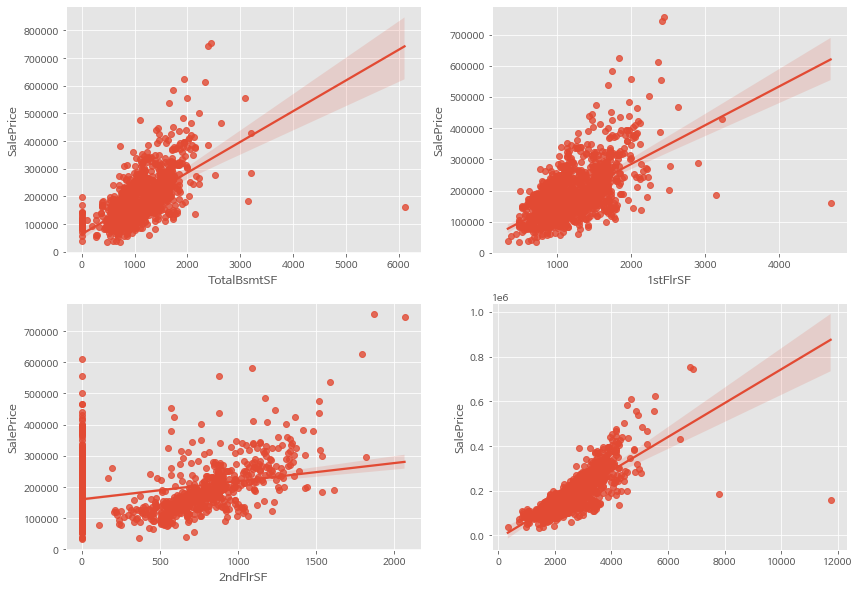

In [14]:


figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.regplot(data['TotalBsmtSF'], data['SalePrice'], ax=ax1) #지하실 면적
sns.regplot(data['1stFlrSF'], data['SalePrice'], ax=ax2) #1층 면적
sns.regplot(data['2ndFlrSF'], data['SalePrice'], ax=ax3) #2층 면적
sns.regplot(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], data['SalePrice'], ax=ax4) #지하실, 1층, 2층 면적을 모두 합한 '총 면적' 

In [15]:
# 이들을 더해서 'TotalSF' 라는 이름으로 저장해야겠다. 

all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

추가로 'No2ndFlr' 과 'NoBsmt' 라는 변수를 만들어서 2층 없음, 지하실 없음 여부를 나타낼 수 있도록 했다.

#### 총 욕실수
FullBath 는 욕조 및 샤워 시설이 포함되어있는 욕실이고, HalfBath는 변기와 세면대 정도 있는 간단한 욕실을 말한다. 
이름에 맞게 FullBath는 1개로 카운트하고, HalfBath 는 0.5개로 카운트해서 모두 더했더니 다음과 같은 그래프

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

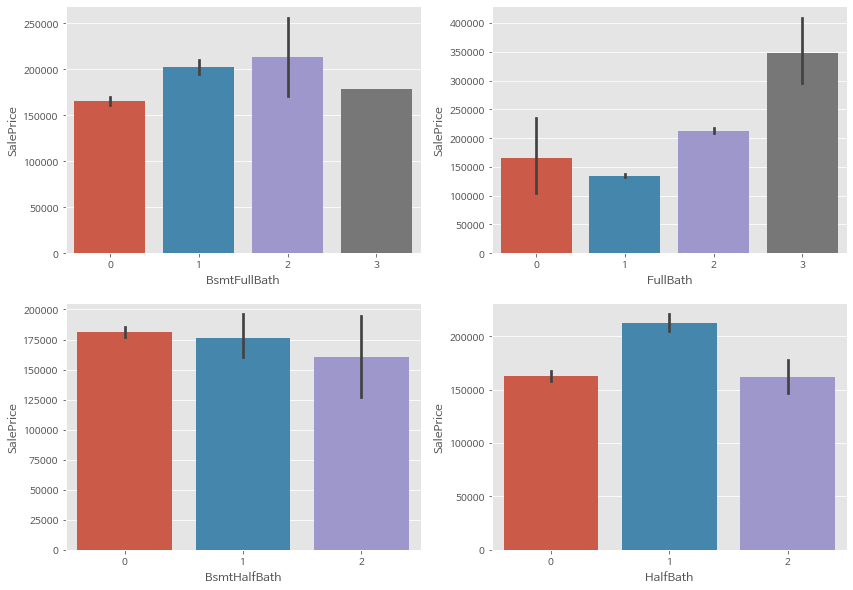

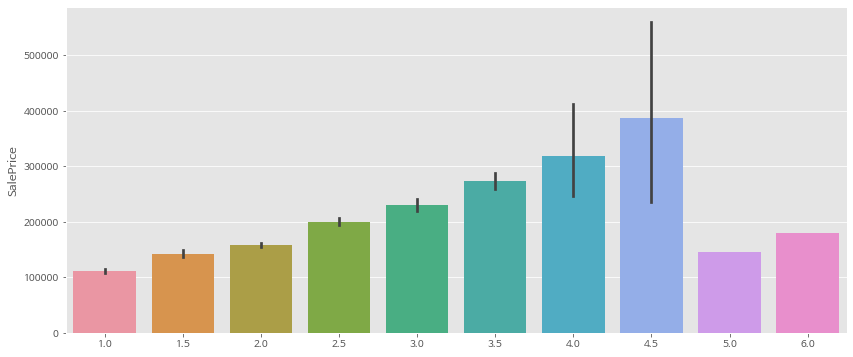

In [16]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(data['BsmtFullBath'], data['SalePrice'], ax=ax1) #지하 욕실
sns.barplot(data['FullBath'], data['SalePrice'], ax=ax2)
sns.barplot(data['BsmtHalfBath'], data['SalePrice'], ax=ax3) #지하 반욕실
sns.barplot(data['HalfBath'], data['SalePrice'], ax=ax4)


figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2), data['SalePrice'], ax=ax5)

저 검정 선은 편차를 의미한다. 그렇다면 편차가 없다는것이 무슨뜻이지? 값이 다른 데이터가 두개만 있어도 편차가 발생할텐데? 화장실 갯수가 5개, 6개인 집은 각각 하나씩밖에 없다는 뜻으로 볼 수 있다. 

이들은 역시 outlier 로 판단하고 지워도 상관이 없다. 

In [17]:
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

In [18]:
all_data[all_data.TotalBath == 6]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,No2ndFlr,NoBsmt,TotalBath
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
739,90,RL,60.0,10800,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,Gd,Gd,GLQ,1200.0,Unf,0.0,0.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3.0,0.0,3,0,3,1,TA,5,Typ,0,None,None,0.0,None,0.0,0.0,None,None,Y,120,0,0,0,0,0,None,None,None,0,3,2009,WD,Alloca,2400.0,True,False,6.0
1840,90,RL,60.0,10800,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,Gd,Gd,Gd,GLQ,1200.0,Unf,0.0,0.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3.0,0.0,3,0,3,1,TA,5,Typ,0,None,None,0.0,None,0.0,0.0,None,None,Y,120,0,0,0,0,0,None,None,None,0,3,2009,WD,Alloca,2400.0,True,False,6.0


#### 3) 건축연도 + 리모델링 연도 (Year Built and Remodeled)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


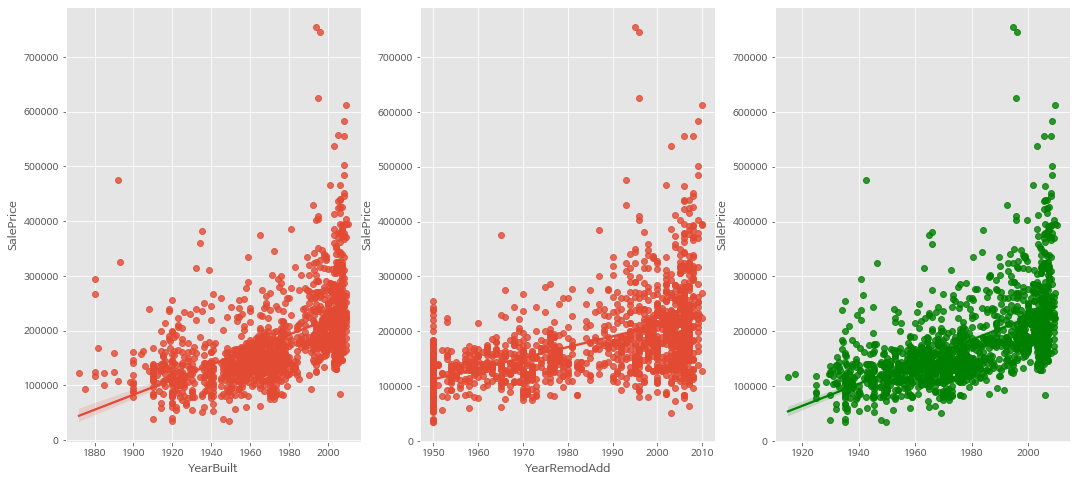

In [19]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(data['YearBuilt'], data['SalePrice'], ax=ax1)
sns.regplot(data['YearRemodAdd'], data['SalePrice'], ax=ax2)
sns.regplot((data['YearBuilt']+data['YearRemodAdd'])/2, data['SalePrice'], color = 'green', ax=ax3) #'/2' for graph scaling

건축 연도가 오래 되었어도, 최근에 리모델링을 하면 이 값이 높게 나왔을 것이고, 건축 이후 리모델링을 하지 않았다면 이 값은 아주 낮게 나왔을 것이다. 따라서 이 값이 높은 집들은 '지어진지 얼마 되지 않은 신축 건물 + 최근에 리모델링까지함' 에 가깝고, 이 값이 낮은 집들은 '오래된 건물 + 리모델링도 안함' 에 가까울 것이다. 그리고 이는 집값에 유의미한 영향이 있다고 초록색 그래프를 보면 판단

In [20]:
#YrBltAndRemod' 라는 이름으로 두 개의 변수를 저장
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

#### 2.5. 자료형 수정 (Correcting Dtypes)


In [21]:
all_data['MSSubClass']=all_data['MSSubClass'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)
all_data['YrSold']=all_data['YrSold'].astype(str)

'MSSubClass' 는 사실 숫자로 이루어진 데이터지만, 각각의 숫자가 의미를 갖고있는 범주형 변수이다. 그리고 판매 연, 월도 역시 연산 개념을 적용하는데는 무리가 있다. 그래서 이들을 문자열로 바꿔주자. 

나는 사람들이 집을 볼때, 1층을 쭉 둘러보고 '괜찮네', 2층을 보고 '별로네', 지하층과 차고를 보고 '좋네' 이런식으로 판단할 거라고 생각했다. 이 평가의 기준 점수는 사람마다 약간 다르겠지만, 해당 시설물을 종합적으로 보고 판단하는 행위는 모두가 비슷할 것이라 생각했다. 나는 그래서 집의 시설물들을 묶어서 점수를 매기기로 했다. 

#### 2.6. 지하실 점수 (Bsmt)

In [22]:
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt=all_data[Basement]

In [23]:
Bsmt

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,
1,TA,No,706.0,0.0,GLQ,Unf,Gd,150.0,856.0
2,TA,Gd,978.0,0.0,ALQ,Unf,Gd,284.0,1262.0
3,TA,Mn,486.0,0.0,GLQ,Unf,Gd,434.0,920.0
4,Gd,No,216.0,0.0,ALQ,Unf,TA,540.0,756.0
5,TA,Av,655.0,0.0,GLQ,Unf,Gd,490.0,1145.0
...,...,...,...,...,...,...,...,...,...
2915,TA,No,0.0,0.0,Unf,Unf,TA,546.0,546.0
2916,TA,No,252.0,0.0,Rec,Unf,TA,294.0,546.0
2917,TA,No,1224.0,0.0,ALQ,Unf,TA,0.0,1224.0


In [24]:
Bsmt=Bsmt.replace(to_replace='Po', value=1)
Bsmt=Bsmt.replace(to_replace='Fa', value=2)
Bsmt=Bsmt.replace(to_replace='TA', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)
Bsmt=Bsmt.replace(to_replace='Ex', value=5)
Bsmt=Bsmt.replace(to_replace='None', value=0)

Bsmt=Bsmt.replace(to_replace='No', value=1)
Bsmt=Bsmt.replace(to_replace='Mn', value=2)
Bsmt=Bsmt.replace(to_replace='Av', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)

Bsmt=Bsmt.replace(to_replace='Unf', value=1)
Bsmt=Bsmt.replace(to_replace='LwQ', value=2)
Bsmt=Bsmt.replace(to_replace='Rec', value=3)
Bsmt=Bsmt.replace(to_replace='BLQ', value=4)
Bsmt=Bsmt.replace(to_replace='ALQ', value=5)
Bsmt=Bsmt.replace(to_replace='GLQ', value=6)

이들을 인코딩해준다. 이 'Po', 'Fa', ... 등의 값은 data description 텍스트 파일에 나와있다. 따라서 순서대로 좋은 값에는 높은 숫자를, 안좋은 값에는 낮은 숫자를, 지하실이 없으면 0을 입력

In [25]:
Bsmt['BsmtScore']= Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore']=Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore']=Bsmt['BsmtFin']
all_data['BsmtDNF']=(all_data['BsmtFinScore']==0)

몇개 항목들을 곱해서 'BsmtScore' 항목을 만들어 지하실의 전반적인 상태를 복합적으로 평가할 수 있는 변수를 만들었다. 

'BsmtFin' 변수는 지하실이 공사중이라면, 완성 면적과 상태를 포함하는 변수

'BsmtFinScore' 은 지하실의 완성도 점수, 

'BsmtScore' 은 지하실의 종합 점수,

 'BsmtDNF' 는 지하실의 미완성 여부를 나타내는 변수

In [26]:
all_data['BsmtFinScore']

Id
1       4236.0
2       4890.0
3       2916.0
4       1080.0
5       3930.0
         ...  
2915       0.0
2916     756.0
2917    6120.0
2918    2022.0
2919    1516.0
Name: BsmtFinScore, Length: 2917, dtype: float64

#### 2.7. 토지 점수 (Lot)

In [28]:
lot=['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot=all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage'] * Lot['LotArea'])+1)

all_data['LotScore']=Lot['LotScore']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,No2ndFlr,NoBsmt,TotalBath,YrBltAndRemod,BsmtScore,BsmtFinScore,BsmtDNF,LotScore
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,2566.0,False,False,3.5,4006,10272.0,4236.0,False,13.216311
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,2524.0,True,False,2.5,3952,15144.0,4890.0,False,13.551546
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,2706.0,False,False,3.5,4003,11040.0,2916.0,False,13.547632
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,2473.0,False,False,2.0,3885,9072.0,1080.0,False,13.258643
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,3343.0,False,False,3.5,4000,13740.0,3930.0,False,13.996031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,None,None,0.0,None,0.0,0.0,None,None,Y,0,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,1638.0,False,False,1.5,3940,4914.0,0.0,True,10.612926
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,N

In [35]:
Lot['LotScore']

Id
1       13.216311
2       13.551546
3       13.547632
4       13.258643
5       13.996031
          ...    
2915    10.612926
2916    10.590994
2917    14.978662
2918    13.380632
2919    13.476393
Name: LotScore, Length: 2917, dtype: float64

#### 2.8. 차고 점수 (Garage)

In [36]:
garage=['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage=all_data[garage]
all_data['NoGarage']=(all_data['GarageArea']==0)

In [37]:
Garage=Garage.replace(to_replace='Po', value=1)
Garage=Garage.replace(to_replace='Fa', value=2)
Garage=Garage.replace(to_replace='TA', value=3)
Garage=Garage.replace(to_replace='Gd', value=4)
Garage=Garage.replace(to_replace='Ex', value=5)
Garage=Garage.replace(to_replace='None', value=0)

Garage=Garage.replace(to_replace='Unf', value=1)
Garage=Garage.replace(to_replace='RFn', value=2)
Garage=Garage.replace(to_replace='Fin', value=3)

Garage=Garage.replace(to_replace='CarPort', value=1)
Garage=Garage.replace(to_replace='Basment', value=4)
Garage=Garage.replace(to_replace='Detchd', value=2)
Garage=Garage.replace(to_replace='2Types', value=3)
Garage=Garage.replace(to_replace='Basement', value=5)
Garage=Garage.replace(to_replace='Attchd', value=6)
Garage=Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore']=Garage['GarageScore']

#### 2.9. 기타 변수 (Other Features)

1) 비정상적으로 하나의 값만 많은 변수들 삭제

In [38]:
all_data=all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

2) 비정상적으로 빈 값이 많은 변수들 삭제

집에 수영장 있는 집이 몇집이나 되겠는가...

그래프를 띄워보면 참 어이가 없다. 



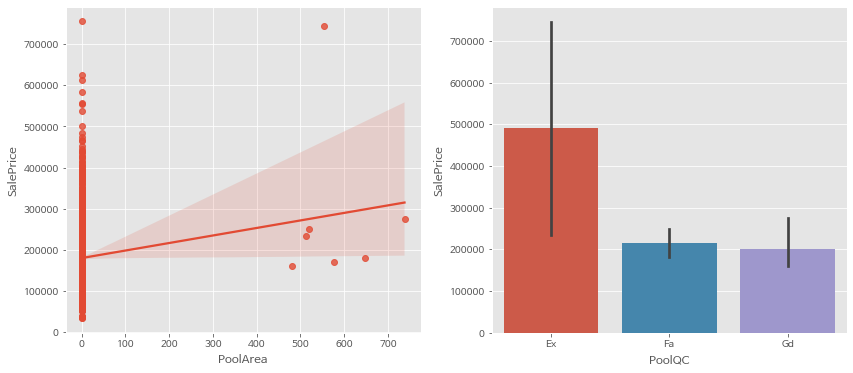

In [39]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='PoolQC', y='SalePrice', ax=ax2)

In [40]:
all_data=all_data.drop(columns=['PoolArea','PoolQC'])

In [41]:
all_data=all_data.drop(columns=['MiscVal','MiscFeature']) #테니스코트

3) 위 둘보다는 낫지만, (채워진)결측치가 많은 경우

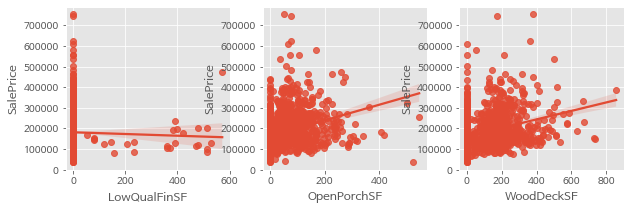

In [42]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(10,3)
sns.regplot(data=data, x='LowQualFinSF', y='SalePrice', ax=ax1)
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice',ax=ax2)
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice',ax=ax3)

이들은 0 값만 분리해주면 결과가 나쁘지 않을 것 같아서 0만 분리해주었다. 



In [43]:
all_data['NoLowQual']=(all_data['LowQualFinSF']==0)
all_data['NoOpenPorch']=(all_data['OpenPorchSF']==0)
all_data['NoWoodDeck']=(all_data['WoodDeckSF']==0)

In [44]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalSF,No2ndFlr,NoBsmt,TotalBath,YrBltAndRemod,BsmtScore,BsmtFinScore,BsmtDNF,LotScore,NoGarage,GarageScore,NoLowQual,NoOpenPorch,NoWoodDeck
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,None,2,2008,WD,Normal,2566.0,False,False,3.5,4006,10272.0,4236.0,False,13.216311,False,39456.0,True,False,True
2,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,None,5,2007,WD,Normal,2524.0,True,False,2.5,3952,15144.0,4890.0,False,13.551546,False,33120.0,True,True,False
3,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,None,9,2008,WD,Normal,2706.0,False,False,3.5,4003,11040.0,2916.0,False,13.547632,False,43776.0,True,False,True
4,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,None,2,2006,WD,Abnorml,2473.0,False,False,2.0,3885,9072.0,1080.0,False,13.258643,False,11556.0,True,False,True
5,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,None,12,2008,WD,Normal,3343.0,False,False,3.5,4000,13740.0,3930.0,False,13.996031,False,90288.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,None,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,None,None,0.0,None,0.0,0.0,None,None,Y,0,0,0,0,0,None,6,2006,WD,Normal,1638.0,False,False,1.5,3940,4914.0,0.0,True,10.612926,True,0.0,True,True,True
2916,160,RM,21.0,1894,None,Reg,Lvl,Inside,Gtl,MeadowV,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,None,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,None,4,2006,WD,Abnorml,1638.0,False,False,1.5,3940,4914.0,756.0,False,10.590994,False,858.0,True,False,True
2917,2

## 3. 전처리 (Preprocessing)
### 3.1. 범주형 변수 (Categorical Feature)

In [45]:
non_numeric=all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) !=0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(all_data[col], prefix=col)
        all_data=pd.merge(all_data, data_encoded, on='Id')
        all_data=all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

(2917, 309)


###3.2. 수치형 변수 (Numeric Feature)
수치형 변수는 비대칭이 너무 심해지지 않게끔, Right Skewed 가 크게 되어있는 데이터들에만 로그를 씌워 적절히 변형시켜준다. 

In [46]:
numeric=all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))

255 features had been tranformed
(2917, 309)


### 데이터 나누기

In [47]:
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Xtest.shape)

(1458, 79) (1459, 79)
(1458, 309) (1459, 309)


In [69]:
all_data.shape

(2917, 309)

원래 train 데이터의 갯수와 데이터를 가공한 Xtrain 데이터의 갯수가 1458 개로 동일하다. (위에서 'GrLivArea' 할 때 train 에서 두개를 지웠었다!)

## 4. 머신러닝 모델로 학습

Lasso, ElasticNet, sklearn의 GradientBoosting, XGBoost 4개의 모델을 불러와서 저장한다. 

최종 예측 결과물은 이 4개의 모델의 예측값의 평균값을 사용해 제출할 것이다. 

In [48]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
#import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, 
                                         min_samples_split=10, loss='huber', random_state=18)

model_XGB=XGBRegressor(colsample_bylevel=0.9229733609038979,colsample_bynode=0.21481791874780318,colsample_bytree=0.607964318297635, 
                       gamma=0.8989889254961725, learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602, 
                       reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
                       tree_method='gpu_hist',verbosity=0)

In [52]:
model_Lasso.fit(Xtrain, Ytrain)
Lasso_predictions=model_Lasso.predict(Xtest)
train_Lasso=model_Lasso.predict(Xtrain)

model_ENet.fit(Xtrain, Ytrain)
ENet_predictions=model_ENet.predict(Xtest)
train_ENet=model_ENet.predict(Xtrain)

#model_XGB.fit(Xtrain, Ytrain)
#XGB_predictions=model_XGB.predict(Xtest)
#train_XGB=model_XGB.predict(Xtrain)

model_GBoost.fit(Xtrain, Ytrain)
GBoost_predictions=model_GBoost.predict(Xtest)
train_GBoost=model_GBoost.predict(Xtrain)

log_train_predictions = (train_Lasso + train_ENet  + train_GBoost)/3 #+ train_XGB
train_score=np.sqrt(mean_squared_error(Ytrain, log_train_predictions))
print(f"Scoring with train data : {train_score}")

log_predictions=(Lasso_predictions + ENet_predictions  + GBoost_predictions) / 3 #+ XGB_predictions
predictions=np.exp(log_predictions)-1
submission['SalePrice']=predictions
submission.to_csv('Result.csv')

Scoring with train data : 0.07808835792510635


,SalePrice
Id,
1461,121121.487982
1462,157157.696737
1463,187558.783967
1464,199394.248663
1465,193971.412202
...,...
2915,85378.813802
2916,81258.793207
2917,167599.257265


In [97]:
Xtrain.isnull().sum()

LotFrontage              259
LotArea                    0
OverallQual                0
OverallCond                0
YearBuilt                  0
                        ... 
SaleCondition_AdjLand      0
SaleCondition_Alloca       0
SaleCondition_Family       0
SaleCondition_Normal       0
SaleCondition_Partial      0
Length: 297, dtype: int64

In [55]:
submission.to_csv('/content/gdrive/MyDrive/prac/Result.csv')

FileNotFoundError: ignored